In [2]:
datapath = "/home/rlele/argovis"

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("/home/rlele/.conda/envs/argovis_demo/lib/python3.8/site-packages")
from utilities_NSF_EC2022 import create_url, get_data_from_url, get_info_from_df,get_data_for_timeRange, \
                                    polygon_lon_lat, mask_QC, simple_plot, qc, interpolate
# for data visualization
from utilities_NSF_EC2022 import set_ax_label, \
                                 set_map_and_plot_locations_withColor

# prefix to use with all API queries
URL_PREFIX = 'https://argovis-api.colorado.edu'
API_KEY   = 'b6436d499d8f4d636ec0f53942d3b809e647b32d'


In [72]:
import xarray as xr
# data processing
import numpy as np
import pandas as pd
from time import sleep

#data visualization
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline

# API convenience functions
from utilities_NSF_EC2022 import get_data_for_timeRange

import warnings
warnings.filterwarnings('ignore')




In [269]:
# more convenient wrapper for if you want a line just by name
def get_goship_line(line_name, startDate='2020-04-01T00:00:00Z', endDate='2021-05-01T00:00:00Z', dt_tag='365d', url=URL_PREFIX, api_key=API_KEY):
    df = get_data_for_timeRange(startDate, endDate, url_prefix=url+'/profiles?', 
                                source='cchdo_go-ship', woceline=line_name, 
                                myAPIkey=api_key, dt_tag=dt_tag)
    return df

# I think we should have a time independent version of this function as well
# could cheat this function into doing it with something like timedelta=1e5 or something
def get_argo_along_line(time, coords, radius=50, timedelta=30, dt_tag='365d', url=URL_PREFIX, api_key=API_KEY):
    df_all = pd.DataFrame()
    for t, c in zip(time, coords):
        sleep(.2)
        startDate = (pd.Timestamp(t) - pd.Timedelta(timedelta/2)).strftime('%Y-%m-%dT%H:%M:%SZ')
        endDate   = (pd.Timestamp(t) + pd.Timedelta(timedelta/2)).strftime('%Y-%m-%dT%H:%M:%SZ')
        center    = f'{c[0]},{c[1]}'
        df = get_data_for_timeRange(startDate, endDate, url_prefix=url+'/profiles?',
            center=center, radius_km=f'{radius}', source='argo_core', data='pres,temp,psal',
            myAPIkey=api_key, dt_tag=dt_tag, writeFlag=False)
        df_all = df_all.append(df)
    
    return df_all

# get argo data along line A22
a22 = get_goship_line('A22')
coords = [c['coordinates'] for c in a22.geolocation]
time = a22.timestamp.values
argo_a22 = get_argo_along_line(time, coords)


# This cell for data loading/processing to xarray

In [270]:
# process data from full of JSON points to more usable form
def json_dataframe_to_dataframe(df):
    out = pd.DataFrame()
    for i in range(df.shape[0]):
        # get the argo data
        data_dict = dict()
        data = df.data.iloc[i]
        # repeat location and time data for same lenth as array
        N_levels = len(data)
        data_dict['wmo'] = N_levels*[int(df._id.iloc[i].split('_')[0])]
        data_dict['cycle_number'] = N_levels*[df.cycle_number.iloc[i]]
        data_dict['time'] = N_levels*[df.timestamp.iloc[i]]
        data_dict['longitude'] = N_levels*[df.geolocation.iloc[i]['coordinates'][0]]
        data_dict['latitude'] = N_levels*[df.geolocation.iloc[i]['coordinates'][1]]
        # extract data from JSON dict
        for k in df.data_keys.iloc[i]:
            data_dict[k] = [d[k] for d in data]

        out = pd.concat((out, pd.DataFrame(data_dict, index=(i+1)*np.ones((N_levels,), dtype=int))))
    
    return out

df = json_dataframe_to_dataframe(argo_a22)

def dataframe_to_xarray(df):
    # get max number of depth levels
    ix = df.index.unique()
    number_profiles = ix.shape[0]
    max_levels = -np.inf
    for nprof in ix:
        if df.loc[nprof].shape[0] > max_levels:
            max_levels = df.loc[nprof].shape[0]

    # extract lower dimension metadata
    metadata = ['wmo', 'cycle_number', 'time', 'longitude', 'latitude']
    meta_dict = dict()
    for k in metadata:
        meta_dict[k] = [df[k].loc[i].iloc[0] for i in ix]
    df = df.drop(metadata, axis=1)
    data_dict = {k:np.nan*np.ones((number_profiles,max_levels)) for k in df.columns}

    # put argo data into "square" arrays
    for nprof in ix:
        profile = df.loc[nprof]
        current_depth_levels = profile.shape[0]
        for k in profile.columns:
            data_dict[k][nprof-1,:current_depth_levels] = profile[k]
    

    # create xarray dataset
    ds = xr.Dataset(
        data_vars = {k:(['n_prof', 'n_level'], v) for k,v in data_dict.items()},
        coords = {k:(['n_prof'], v) for k,v in meta_dict.items()}
    )
    
    # transpose dims for easier plotting
    ds = ds.transpose('n_level','n_prof')
    return ds


In [271]:
ds = dataframe_to_xarray(df)
ds


<xarray.Dataset>
Dimensions:       (n_prof: 6, n_level: 507)
Coordinates:
    wmo           (n_prof) int64 4903349 4903349 4903351 4903350 4903347 4903347
    cycle_number  (n_prof) int64 0 1 0 0 0 0
    time          (n_prof) <U24 '2021-04-24T08:41:23.000Z' ... '2021-04-30T19...
    longitude     (n_prof) float64 -69.7 -69.72 -69.52 -66.47 -66.0 -66.0
    latitude      (n_prof) float64 14.15 14.17 15.2 17.08 19.69 19.69
Dimensions without coordinates: n_prof, n_level
Data variables:
    pres          (n_level, n_prof) float64 1.04 0.96 1.0 1.0 ... nan nan nan
    psal          (n_level, n_prof) float64 35.91 35.92 35.88 ... nan nan nan
    temp          (n_level, n_prof) float64 27.28 27.41 27.36 ... nan nan nan

# This cell is for Data Visualization

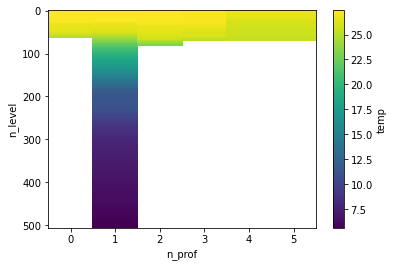

In [278]:
ds.temp.plot(yincrease=False)

# This cell for Data Interpolation/Comparison

In [141]:
# process data from full of JSON points to more usable form 
# modified rlele
def json_dataframe_to_dataframe(df):
    
    out = pd.DataFrame()
    #out1 = pd.DataFrame() 
    for i in range(df.shape[0]):
        # get the argo data
        data_dict = dict()
        data = df.data.iloc[i]
        # repeat location and time data for same lenth as array
        N_levels = len(data)
        data_dict['wmo'] = N_levels*[int(df._id.iloc[i].split('_')[0])]
        data_dict['cycle_number'] = N_levels*[df.cycle_number.iloc[i]]
        data_dict['time'] = N_levels*[df.timestamp.iloc[i]]
        data_dict['longitude'] = N_levels*[df.geolocation.iloc[i]['coordinates'][0]]
        data_dict['latitude'] = N_levels*[df.geolocation.iloc[i]['coordinates'][1]]
        # extract data from JSON dict
        for k in df.data_keys.iloc[i]:
            data_dict[k] = [d[k] for d in data]
        
        test_dict = dict()
        # create new dict to store data as xarray wants
        test_dict = {i:{"dims":('levels'), "data":da[i]} for i in da.keys() } 
        
        #create dataset and expand dims
        test_df = xr.Dataset.from_dict(test_dict)
        test_df = test_df.expand_dims('n_profile')
        
        
        out = out.append(pd.DataFrame(data_dict))
        
    return out,data_dict

df,da = json_dataframe_to_dataframe(argo_a22)
ds = df.to_xarray()

In [158]:
test_df = pd.DataFrame(da)
test_xr = test_df.to_xarray(d)

In [ ]:
a = list(da.keys())

da[a[-1]]

In [189]:
del test_dict

In [192]:
test_dict = {i:{"dims":('levels'), "data":da[i]} for i in da.keys() }

In [205]:
test_df = xr.Dataset.from_dict(test_dict)
test_df = test_df.expand_dims('n_profile')

In [250]:
test_df1 = test_df

In [253]:
test_df1 = xr.Dataset()

In [257]:
test_df1= xr.merge([test_df1,test_df])

In [251]:
test_df1= xr.concat([test_df1,test_df],dim='n_profile')

In [258]:
test_df1

<xarray.Dataset>
Dimensions:       (n_profile: 1, levels: 515)
Dimensions without coordinates: n_profile, levels
Data variables:
    wmo           (n_profile, levels) int64 4903345 4903345 ... 4903345 4903345
    cycle_number  (n_profile, levels) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    time          (n_profile, levels) <U24 '2021-05-02T19:46:44.002Z' ... '20...
    longitude     (n_profile, levels) float64 -65.91 -65.91 ... -65.91 -65.91
    latitude      (n_profile, levels) float64 21.84 21.84 21.84 ... 21.84 21.84
    pres          (n_profile, levels) float64 1.04 2.0 ... 1.018e+03 1.019e+03
    psal          (n_profile, levels) float64 36.41 36.41 36.4 ... 35.01 35.01
    temp          (n_profile, levels) float64 27.02 27.02 27.02 ... 6.637 6.635

In [232]:
#a0 = xr.Dataset()


a0.combine_first(test_df)

<xarray.Dataset>
Dimensions:       (n_profile: 1, levels: 515)
Dimensions without coordinates: n_profile, levels
Data variables:
    wmo           (n_profile, levels) float64 4.903e+06 4.903e+06 ... 4.903e+06
    cycle_number  (n_profile, levels) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    time          (n_profile, levels) object '2021-05-02T19:46:44.002Z' ... '...
    longitude     (n_profile, levels) float64 -65.91 -65.91 ... -65.91 -65.91
    latitude      (n_profile, levels) float64 21.84 21.84 21.84 ... 21.84 21.84
    pres          (n_profile, levels) float64 1.04 2.0 ... 1.018e+03 1.019e+03
    psal          (n_profile, levels) float64 36.41 36.41 36.4 ... 35.01 35.01
    temp          (n_profile, levels) float64 27.02 27.02 27.02 ... 6.637 6.635

In [239]:
test_df2 = test_df1.transpose('levels','n_profile')

In [240]:
test_df2

<xarray.Dataset>
Dimensions:       (n_profile: 4, levels: 515)
Dimensions without coordinates: n_profile, levels
Data variables:
    wmo           (levels, n_profile) int64 4903345 4903345 ... 4903345 4903345
    cycle_number  (levels, n_profile) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    time          (levels, n_profile) <U24 '2021-05-02T19:46:44.002Z' ... '20...
    longitude     (levels, n_profile) float64 -65.91 -65.91 ... -65.91 -65.91
    latitude      (levels, n_profile) float64 21.84 21.84 21.84 ... 21.84 21.84
    pres          (levels, n_profile) float64 1.04 1.04 ... 1.019e+03 1.019e+03
    psal          (levels, n_profile) float64 36.41 36.41 36.41 ... 35.01 35.01
    temp          (levels, n_profile) float64 27.02 27.02 27.02 ... 6.635 6.635

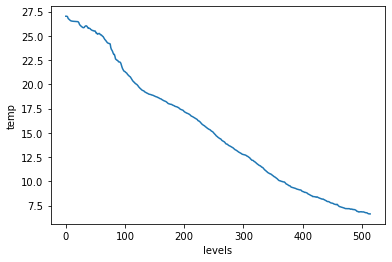

In [200]:
test_df.temp

In [175]:
ds = xr.Dataset.from_dict(d)
ds.a

<xarray.DataArray 'a' (t: 3)>
array(['a', 'b', 'c'], dtype='<U1')
Coordinates:
  * t        (t) int64 0 1 2

In [148]:
b = xr.Dataset()
for i in da.keys():
    

wmo
cycle_number
time
longitude
latitude
pres
psal
temp


In [123]:
# process data from full of JSON points to more usable form
def json_dataframe_to_dataframe(df):
    
    out = pd.DataFrame()
    #out1 = pd.DataFrame() 
    for i in range(df.shape[0]):
        # get the argo data
        data_dict = dict()
        data = df.data.iloc[i]
        # repeat location and time data for same lenth as array
        N_levels = len(data)
        data_dict['wmo'] = N_levels*[int(df._id.iloc[i].split('_')[0])]
        data_dict['cycle_number'] = N_levels*[df.cycle_number.iloc[i]]
        data_dict['time'] = N_levels*[df.timestamp.iloc[i]]
        data_dict['longitude'] = N_levels*[df.geolocation.iloc[i]['coordinates'][0]]
        data_dict['latitude'] = N_levels*[df.geolocation.iloc[i]['coordinates'][1]]
        # extract data from JSON dict
        for k in df.data_keys.iloc[i]:
            data_dict[k] = [d[k] for d in data]
    
        #out1=out
        out = out.append(pd.DataFrame(data_dict))
        #out1 = pd.concat((out,pd.DataFrame(data_dict)),axis=1,ignore_index=True)
    return out

df = json_dataframe_to_dataframe(argo_a22)
ds = df.to_xarray()

Index(['wmo', 'cycle_number', 'time', 'longitude', 'latitude', 'pres', 'psal',
       'temp'],
      dtype='object')